In [1]:
import json
import re
from collections import defaultdict
from transformers import pipeline
import pandas as pd
import torch
import warnings
from datasets import Dataset
import matplotlib.pyplot as plt
from tabulate import tabulate

c:\Users\feder\Desktop\SMMproject\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device")

NVIDIA GeForce RTX 2060 SUPER


In [3]:
INPUT_PATH = "commenti_associabili.json"

soggetti = {
    "stefania": ["stefania", "stefania cappa"],
    "paola": ["paola", "paola cappa"],
    "andrea": ["andrea", "andrea sempio", "sempio"],
    "alberto": ["alberto", "alberto stasi", "stasi"],
    "marco": ["marco", "marco poggi"],
    "stefania e paola": ["stefania cappa e paola cappa", "stefania e paola", "gemelle cappa", "gemelle", "sorelle"],
}

genere_soggetti = {
    "stefania": "femminile",
    "paola": "femminile",
    "andrea": "maschile",
    "alberto": "maschile",
    "marco": "maschile",
    "stefania e paola": "femminile",
}

In [4]:
def pulisci_testo(testo):
    testo = testo.lower()
    testo = re.sub(r"http\S+", "", testo)
    testo = re.sub(r"@\w+", "", testo)
    testo = re.sub(r"[^a-zA-Zàèéìòùç0-9\s']", " ", testo)
    testo = re.sub(r"\s+", " ", testo)
    return testo.strip()

In [5]:
with open(INPUT_PATH, "r", encoding="utf-8") as f:
    all_comments = json.load(f)

In [6]:
warnings.filterwarnings("ignore", category=UserWarning, module="torch.utils.data.dataloader")

classifier = pipeline(
    "zero-shot-classification",
    model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli",
    device=0,
    truncation=True
)

etichette = ["colpevole", "innocente", "neutro"]
template = "Il soggetto è {}."

texts = []
matched_subjects = []
dates = []
original_comments = []
genres = []

for c in all_comments:
    testo_pulito = pulisci_testo(c["content"])
    soggetto_trovato = None
    for soggetto, varianti in soggetti.items():
        if any(v in testo_pulito for v in varianti):
            soggetto_trovato = soggetto
            break
    if soggetto_trovato:
        texts.append(c["content"])
        matched_subjects.append(soggetto_trovato)
        dates.append(c["date"])
        original_comments.append(c["content"])
        genres.append(genere_soggetti[soggetto_trovato])

dataset = Dataset.from_dict({
    "text": texts,
    "subject": matched_subjects,
    "genre": genres,
    "date": dates,
    "original_comment": original_comments,
})

giudizi = defaultdict(lambda: {"colpevole": 0, "innocente": 0, "neutro": 0})
giudizi_per_genere = defaultdict(lambda: {"colpevole": 0, "innocente": 0, "neutro": 0})
dettagli = []

total = len(dataset)
print(f"Commenti da classificare: {total}")
total_classified = 0

def classify_batch(batch):
    outputs = classifier(
        batch["text"],
        candidate_labels=etichette,
        hypothesis_template=template,
        multi_label=False
    )
    global total_classified
    total_classified += len(outputs)
    print(f"Classificati {total_classified}/{total} ({total_classified / total * 100:.2f}%) commenti...")
    return {"pred_label": [out["labels"][0] for out in outputs]}

results = dataset.map(
    classify_batch,
    batched=True,
    batch_size=64,
)

for i in range(len(results)):
    soggetto = results[i]["subject"]
    genere = results[i]["genre"]
    label = results[i]["pred_label"]
    giudizi[soggetto][label] += 1
    giudizi_per_genere[genere][label] += 1
    dettagli.append({
        "soggetto": soggetto,
        "genere": genere,
        "data": results[i]["date"],
        "giudizio": label,
        "commento": results[i]["original_comment"],
    })

print("Classificazione completata.")

Commenti da classificare: 14718


Map:   0%|          | 64/14718 [00:04<16:52, 14.47 examples/s]

Classificati 64/14718 (0.43%) commenti...


Map:   1%|          | 128/14718 [00:09<17:39, 13.77 examples/s]

Classificati 128/14718 (0.87%) commenti...


Map:   1%|▏         | 192/14718 [00:13<16:12, 14.94 examples/s]

Classificati 192/14718 (1.30%) commenti...


Map:   2%|▏         | 256/14718 [00:16<15:19, 15.74 examples/s]

Classificati 256/14718 (1.74%) commenti...


Map:   2%|▏         | 320/14718 [00:20<14:42, 16.31 examples/s]

Classificati 320/14718 (2.17%) commenti...


Map:   3%|▎         | 384/14718 [00:24<14:34, 16.38 examples/s]

Classificati 384/14718 (2.61%) commenti...


Map:   3%|▎         | 448/14718 [00:27<14:04, 16.89 examples/s]

Classificati 448/14718 (3.04%) commenti...


Map:   3%|▎         | 512/14718 [00:31<13:40, 17.31 examples/s]

Classificati 512/14718 (3.48%) commenti...


Map:   4%|▍         | 576/14718 [00:35<13:43, 17.18 examples/s]

Classificati 576/14718 (3.91%) commenti...


Map:   4%|▍         | 640/14718 [00:38<13:28, 17.42 examples/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Classificati 640/14718 (4.35%) commenti...


Map:   5%|▍         | 704/14718 [00:42<13:52, 16.83 examples/s]

Classificati 704/14718 (4.78%) commenti...


Map:   5%|▌         | 768/14718 [00:46<13:45, 16.90 examples/s]

Classificati 768/14718 (5.22%) commenti...


Map:   6%|▌         | 832/14718 [00:51<14:46, 15.67 examples/s]

Classificati 832/14718 (5.65%) commenti...


Map:   6%|▌         | 896/14718 [00:55<14:18, 16.11 examples/s]

Classificati 896/14718 (6.09%) commenti...


Map:   7%|▋         | 960/14718 [00:59<14:24, 15.92 examples/s]

Classificati 960/14718 (6.52%) commenti...


Map:   7%|▋         | 1024/14718 [01:02<13:56, 16.38 examples/s]

Classificati 1024/14718 (6.96%) commenti...


Map:   7%|▋         | 1088/14718 [01:06<13:51, 16.39 examples/s]

Classificati 1088/14718 (7.39%) commenti...


Map:   8%|▊         | 1152/14718 [01:10<13:27, 16.81 examples/s]

Classificati 1152/14718 (7.83%) commenti...


Map:   8%|▊         | 1216/14718 [01:14<13:20, 16.87 examples/s]

Classificati 1216/14718 (8.26%) commenti...


Map:   9%|▊         | 1280/14718 [01:17<13:21, 16.76 examples/s]

Classificati 1280/14718 (8.70%) commenti...


Map:   9%|▉         | 1344/14718 [01:21<13:05, 17.02 examples/s]

Classificati 1344/14718 (9.13%) commenti...


Map:  10%|▉         | 1408/14718 [01:25<13:07, 16.90 examples/s]

Classificati 1408/14718 (9.57%) commenti...


Map:  10%|█         | 1472/14718 [01:29<13:01, 16.95 examples/s]

Classificati 1472/14718 (10.00%) commenti...


Map:  10%|█         | 1536/14718 [01:33<13:07, 16.73 examples/s]

Classificati 1536/14718 (10.44%) commenti...


Map:  11%|█         | 1600/14718 [01:36<13:05, 16.69 examples/s]

Classificati 1600/14718 (10.87%) commenti...


Map:  11%|█▏        | 1664/14718 [01:40<12:57, 16.79 examples/s]

Classificati 1664/14718 (11.31%) commenti...


Map:  12%|█▏        | 1728/14718 [01:45<13:33, 15.96 examples/s]

Classificati 1728/14718 (11.74%) commenti...


Map:  12%|█▏        | 1792/14718 [01:48<13:09, 16.38 examples/s]

Classificati 1792/14718 (12.18%) commenti...


Map:  13%|█▎        | 1856/14718 [01:52<12:59, 16.51 examples/s]

Classificati 1856/14718 (12.61%) commenti...


Map:  13%|█▎        | 1920/14718 [01:56<13:01, 16.37 examples/s]

Classificati 1920/14718 (13.05%) commenti...


Map:  13%|█▎        | 1984/14718 [02:01<14:01, 15.14 examples/s]

Classificati 1984/14718 (13.48%) commenti...


Map:  14%|█▍        | 2048/14718 [02:05<13:54, 15.19 examples/s]

Classificati 2048/14718 (13.91%) commenti...


Map:  14%|█▍        | 2112/14718 [02:10<14:03, 14.94 examples/s]

Classificati 2112/14718 (14.35%) commenti...


Map:  15%|█▍        | 2176/14718 [02:14<13:34, 15.40 examples/s]

Classificati 2176/14718 (14.78%) commenti...


Map:  15%|█▌        | 2240/14718 [02:18<13:32, 15.36 examples/s]

Classificati 2240/14718 (15.22%) commenti...


Map:  16%|█▌        | 2304/14718 [02:22<13:27, 15.36 examples/s]

Classificati 2304/14718 (15.65%) commenti...


Map:  16%|█▌        | 2368/14718 [02:26<13:11, 15.61 examples/s]

Classificati 2368/14718 (16.09%) commenti...


Map:  17%|█▋        | 2432/14718 [02:30<12:52, 15.89 examples/s]

Classificati 2432/14718 (16.52%) commenti...


Map:  17%|█▋        | 2496/14718 [02:34<12:47, 15.92 examples/s]

Classificati 2496/14718 (16.96%) commenti...


Map:  17%|█▋        | 2560/14718 [02:37<12:24, 16.32 examples/s]

Classificati 2560/14718 (17.39%) commenti...


Map:  18%|█▊        | 2624/14718 [02:41<12:23, 16.27 examples/s]

Classificati 2624/14718 (17.83%) commenti...


Map:  18%|█▊        | 2688/14718 [02:46<12:30, 16.03 examples/s]

Classificati 2688/14718 (18.26%) commenti...


Map:  19%|█▊        | 2752/14718 [02:49<12:07, 16.45 examples/s]

Classificati 2752/14718 (18.70%) commenti...


Map:  19%|█▉        | 2816/14718 [02:53<11:42, 16.93 examples/s]

Classificati 2816/14718 (19.13%) commenti...


Map:  20%|█▉        | 2880/14718 [02:57<11:40, 16.89 examples/s]

Classificati 2880/14718 (19.57%) commenti...


Map:  20%|██        | 2944/14718 [03:00<11:19, 17.33 examples/s]

Classificati 2944/14718 (20.00%) commenti...


Map:  20%|██        | 3008/14718 [03:04<11:32, 16.92 examples/s]

Classificati 3008/14718 (20.44%) commenti...


Map:  21%|██        | 3072/14718 [03:08<11:32, 16.81 examples/s]

Classificati 3072/14718 (20.87%) commenti...


Map:  21%|██▏       | 3136/14718 [03:11<11:17, 17.10 examples/s]

Classificati 3136/14718 (21.31%) commenti...


Map:  22%|██▏       | 3200/14718 [03:16<11:33, 16.60 examples/s]

Classificati 3200/14718 (21.74%) commenti...


Map:  22%|██▏       | 3264/14718 [03:20<12:00, 15.89 examples/s]

Classificati 3264/14718 (22.18%) commenti...


Map:  23%|██▎       | 3328/14718 [03:24<11:36, 16.35 examples/s]

Classificati 3328/14718 (22.61%) commenti...


Map:  23%|██▎       | 3392/14718 [03:28<11:43, 16.11 examples/s]

Classificati 3392/14718 (23.05%) commenti...


Map:  23%|██▎       | 3456/14718 [03:32<12:03, 15.57 examples/s]

Classificati 3456/14718 (23.48%) commenti...


Map:  24%|██▍       | 3520/14718 [03:37<12:10, 15.33 examples/s]

Classificati 3520/14718 (23.92%) commenti...


Map:  24%|██▍       | 3584/14718 [03:41<12:12, 15.20 examples/s]

Classificati 3584/14718 (24.35%) commenti...


Map:  25%|██▍       | 3648/14718 [03:45<12:22, 14.91 examples/s]

Classificati 3648/14718 (24.79%) commenti...


Map:  25%|██▌       | 3712/14718 [03:49<12:08, 15.11 examples/s]

Classificati 3712/14718 (25.22%) commenti...


Map:  26%|██▌       | 3776/14718 [03:54<12:11, 14.96 examples/s]

Classificati 3776/14718 (25.66%) commenti...


Map:  26%|██▌       | 3840/14718 [03:58<12:01, 15.07 examples/s]

Classificati 3840/14718 (26.09%) commenti...


Map:  27%|██▋       | 3904/14718 [04:02<11:53, 15.15 examples/s]

Classificati 3904/14718 (26.53%) commenti...


Map:  27%|██▋       | 3968/14718 [04:07<11:59, 14.93 examples/s]

Classificati 3968/14718 (26.96%) commenti...


Map:  27%|██▋       | 4032/14718 [04:10<11:36, 15.34 examples/s]

Classificati 4032/14718 (27.40%) commenti...


Map:  28%|██▊       | 4096/14718 [04:15<11:48, 15.00 examples/s]

Classificati 4096/14718 (27.83%) commenti...


Map:  28%|██▊       | 4160/14718 [04:20<12:24, 14.18 examples/s]

Classificati 4160/14718 (28.26%) commenti...


Map:  29%|██▊       | 4224/14718 [04:26<13:14, 13.21 examples/s]

Classificati 4224/14718 (28.70%) commenti...


Map:  29%|██▉       | 4288/14718 [04:30<12:35, 13.81 examples/s]

Classificati 4288/14718 (29.13%) commenti...


Map:  30%|██▉       | 4352/14718 [04:35<13:08, 13.15 examples/s]

Classificati 4352/14718 (29.57%) commenti...


Map:  30%|███       | 4416/14718 [04:39<12:16, 13.98 examples/s]

Classificati 4416/14718 (30.00%) commenti...


Map:  30%|███       | 4480/14718 [04:43<11:55, 14.31 examples/s]

Classificati 4480/14718 (30.44%) commenti...


Map:  31%|███       | 4544/14718 [04:48<11:44, 14.43 examples/s]

Classificati 4544/14718 (30.87%) commenti...


Map:  31%|███▏      | 4608/14718 [04:52<11:25, 14.76 examples/s]

Classificati 4608/14718 (31.31%) commenti...


Map:  32%|███▏      | 4672/14718 [04:56<11:23, 14.70 examples/s]

Classificati 4672/14718 (31.74%) commenti...


Map:  32%|███▏      | 4736/14718 [05:01<11:27, 14.52 examples/s]

Classificati 4736/14718 (32.18%) commenti...


Map:  33%|███▎      | 4800/14718 [05:05<11:07, 14.85 examples/s]

Classificati 4800/14718 (32.61%) commenti...


Map:  33%|███▎      | 4864/14718 [05:09<10:56, 15.01 examples/s]

Classificati 4864/14718 (33.05%) commenti...


Map:  33%|███▎      | 4928/14718 [05:13<11:01, 14.80 examples/s]

Classificati 4928/14718 (33.48%) commenti...


Map:  34%|███▍      | 4992/14718 [05:17<10:43, 15.11 examples/s]

Classificati 4992/14718 (33.92%) commenti...


Map:  34%|███▍      | 5056/14718 [05:21<10:27, 15.40 examples/s]

Classificati 5056/14718 (34.35%) commenti...


Map:  35%|███▍      | 5120/14718 [05:25<09:56, 16.09 examples/s]

Classificati 5120/14718 (34.79%) commenti...


Map:  35%|███▌      | 5184/14718 [05:28<09:27, 16.81 examples/s]

Classificati 5184/14718 (35.22%) commenti...


Map:  36%|███▌      | 5248/14718 [05:32<09:10, 17.21 examples/s]

Classificati 5248/14718 (35.66%) commenti...


Map:  36%|███▌      | 5312/14718 [05:36<09:01, 17.39 examples/s]

Classificati 5312/14718 (36.09%) commenti...


Map:  37%|███▋      | 5376/14718 [05:39<08:49, 17.65 examples/s]

Classificati 5376/14718 (36.53%) commenti...


Map:  37%|███▋      | 5440/14718 [05:43<08:41, 17.78 examples/s]

Classificati 5440/14718 (36.96%) commenti...


Map:  37%|███▋      | 5504/14718 [05:46<08:42, 17.63 examples/s]

Classificati 5504/14718 (37.40%) commenti...


Map:  38%|███▊      | 5568/14718 [05:50<08:40, 17.59 examples/s]

Classificati 5568/14718 (37.83%) commenti...


Map:  38%|███▊      | 5632/14718 [05:53<08:31, 17.76 examples/s]

Classificati 5632/14718 (38.27%) commenti...


Map:  39%|███▊      | 5696/14718 [05:57<08:30, 17.69 examples/s]

Classificati 5696/14718 (38.70%) commenti...


Map:  39%|███▉      | 5760/14718 [06:01<08:29, 17.58 examples/s]

Classificati 5760/14718 (39.14%) commenti...


Map:  40%|███▉      | 5824/14718 [06:05<08:52, 16.70 examples/s]

Classificati 5824/14718 (39.57%) commenti...


Map:  40%|████      | 5888/14718 [06:09<08:58, 16.40 examples/s]

Classificati 5888/14718 (40.01%) commenti...


Map:  40%|████      | 5952/14718 [06:13<08:53, 16.43 examples/s]

Classificati 5952/14718 (40.44%) commenti...


Map:  41%|████      | 6016/14718 [06:17<08:47, 16.50 examples/s]

Classificati 6016/14718 (40.88%) commenti...


Map:  41%|████▏     | 6080/14718 [06:20<08:28, 16.98 examples/s]

Classificati 6080/14718 (41.31%) commenti...


Map:  42%|████▏     | 6144/14718 [06:25<08:48, 16.22 examples/s]

Classificati 6144/14718 (41.74%) commenti...


Map:  42%|████▏     | 6208/14718 [06:29<08:49, 16.08 examples/s]

Classificati 6208/14718 (42.18%) commenti...


Map:  43%|████▎     | 6272/14718 [06:34<09:24, 14.96 examples/s]

Classificati 6272/14718 (42.61%) commenti...


Map:  43%|████▎     | 6336/14718 [06:39<09:58, 14.00 examples/s]

Classificati 6336/14718 (43.05%) commenti...


Map:  43%|████▎     | 6400/14718 [06:44<10:10, 13.62 examples/s]

Classificati 6400/14718 (43.48%) commenti...


Map:  44%|████▍     | 6464/14718 [06:49<10:09, 13.53 examples/s]

Classificati 6464/14718 (43.92%) commenti...


Map:  44%|████▍     | 6528/14718 [06:53<09:50, 13.86 examples/s]

Classificati 6528/14718 (44.35%) commenti...


Map:  45%|████▍     | 6592/14718 [06:57<09:17, 14.57 examples/s]

Classificati 6592/14718 (44.79%) commenti...


Map:  45%|████▌     | 6656/14718 [07:02<09:20, 14.39 examples/s]

Classificati 6656/14718 (45.22%) commenti...


Map:  46%|████▌     | 6720/14718 [07:05<08:50, 15.07 examples/s]

Classificati 6720/14718 (45.66%) commenti...


Map:  46%|████▌     | 6784/14718 [07:09<08:29, 15.57 examples/s]

Classificati 6784/14718 (46.09%) commenti...


Map:  47%|████▋     | 6848/14718 [07:14<08:54, 14.73 examples/s]

Classificati 6848/14718 (46.53%) commenti...


Map:  47%|████▋     | 6912/14718 [07:18<08:27, 15.39 examples/s]

Classificati 6912/14718 (46.96%) commenti...


Map:  47%|████▋     | 6976/14718 [07:22<08:17, 15.57 examples/s]

Classificati 6976/14718 (47.40%) commenti...


Map:  48%|████▊     | 7040/14718 [07:26<08:05, 15.83 examples/s]

Classificati 7040/14718 (47.83%) commenti...


Map:  48%|████▊     | 7104/14718 [07:29<07:52, 16.11 examples/s]

Classificati 7104/14718 (48.27%) commenti...


Map:  49%|████▊     | 7168/14718 [07:33<07:42, 16.31 examples/s]

Classificati 7168/14718 (48.70%) commenti...


Map:  49%|████▉     | 7232/14718 [07:38<08:14, 15.14 examples/s]

Classificati 7232/14718 (49.14%) commenti...


Map:  50%|████▉     | 7296/14718 [07:43<08:11, 15.09 examples/s]

Classificati 7296/14718 (49.57%) commenti...


Map:  50%|█████     | 7360/14718 [07:46<07:48, 15.71 examples/s]

Classificati 7360/14718 (50.01%) commenti...


Map:  50%|█████     | 7424/14718 [07:50<07:30, 16.21 examples/s]

Classificati 7424/14718 (50.44%) commenti...


Map:  51%|█████     | 7488/14718 [07:54<07:22, 16.33 examples/s]

Classificati 7488/14718 (50.88%) commenti...


Map:  51%|█████▏    | 7552/14718 [07:57<07:14, 16.51 examples/s]

Classificati 7552/14718 (51.31%) commenti...


Map:  52%|█████▏    | 7616/14718 [08:01<06:57, 17.00 examples/s]

Classificati 7616/14718 (51.75%) commenti...


Map:  52%|█████▏    | 7680/14718 [08:05<07:00, 16.75 examples/s]

Classificati 7680/14718 (52.18%) commenti...


Map:  53%|█████▎    | 7744/14718 [08:09<07:02, 16.51 examples/s]

Classificati 7744/14718 (52.62%) commenti...


Map:  53%|█████▎    | 7808/14718 [08:13<06:53, 16.70 examples/s]

Classificati 7808/14718 (53.05%) commenti...


Map:  53%|█████▎    | 7872/14718 [08:17<07:04, 16.11 examples/s]

Classificati 7872/14718 (53.49%) commenti...


Map:  54%|█████▍    | 7936/14718 [08:21<06:49, 16.54 examples/s]

Classificati 7936/14718 (53.92%) commenti...


Map:  54%|█████▍    | 8000/14718 [08:25<06:47, 16.48 examples/s]

Classificati 8000/14718 (54.36%) commenti...


Map:  55%|█████▍    | 8064/14718 [08:28<06:42, 16.52 examples/s]

Classificati 8064/14718 (54.79%) commenti...


Map:  55%|█████▌    | 8128/14718 [08:32<06:33, 16.75 examples/s]

Classificati 8128/14718 (55.22%) commenti...


Map:  56%|█████▌    | 8192/14718 [08:36<06:33, 16.57 examples/s]

Classificati 8192/14718 (55.66%) commenti...


Map:  56%|█████▌    | 8256/14718 [08:40<06:33, 16.42 examples/s]

Classificati 8256/14718 (56.09%) commenti...


Map:  57%|█████▋    | 8320/14718 [08:44<06:26, 16.57 examples/s]

Classificati 8320/14718 (56.53%) commenti...


Map:  57%|█████▋    | 8384/14718 [08:48<06:27, 16.33 examples/s]

Classificati 8384/14718 (56.96%) commenti...


Map:  57%|█████▋    | 8448/14718 [08:52<06:35, 15.87 examples/s]

Classificati 8448/14718 (57.40%) commenti...


Map:  58%|█████▊    | 8512/14718 [08:56<06:27, 16.00 examples/s]

Classificati 8512/14718 (57.83%) commenti...


Map:  58%|█████▊    | 8576/14718 [09:00<06:13, 16.43 examples/s]

Classificati 8576/14718 (58.27%) commenti...


Map:  59%|█████▊    | 8640/14718 [09:04<06:10, 16.42 examples/s]

Classificati 8640/14718 (58.70%) commenti...


Map:  59%|█████▉    | 8704/14718 [09:08<06:09, 16.26 examples/s]

Classificati 8704/14718 (59.14%) commenti...


Map:  60%|█████▉    | 8768/14718 [09:12<06:04, 16.32 examples/s]

Classificati 8768/14718 (59.57%) commenti...


Map:  60%|██████    | 8832/14718 [09:15<05:53, 16.67 examples/s]

Classificati 8832/14718 (60.01%) commenti...


Map:  60%|██████    | 8896/14718 [09:19<05:49, 16.67 examples/s]

Classificati 8896/14718 (60.44%) commenti...


Map:  61%|██████    | 8960/14718 [09:23<05:46, 16.64 examples/s]

Classificati 8960/14718 (60.88%) commenti...


Map:  61%|██████▏   | 9024/14718 [09:27<05:56, 15.96 examples/s]

Classificati 9024/14718 (61.31%) commenti...


Map:  62%|██████▏   | 9088/14718 [09:31<05:56, 15.79 examples/s]

Classificati 9088/14718 (61.75%) commenti...


Map:  62%|██████▏   | 9152/14718 [09:36<05:58, 15.54 examples/s]

Classificati 9152/14718 (62.18%) commenti...


Map:  63%|██████▎   | 9216/14718 [09:40<06:02, 15.16 examples/s]

Classificati 9216/14718 (62.62%) commenti...


Map:  63%|██████▎   | 9280/14718 [09:44<05:48, 15.60 examples/s]

Classificati 9280/14718 (63.05%) commenti...


Map:  63%|██████▎   | 9344/14718 [09:48<05:41, 15.72 examples/s]

Classificati 9344/14718 (63.49%) commenti...


Map:  64%|██████▍   | 9408/14718 [09:52<05:38, 15.68 examples/s]

Classificati 9408/14718 (63.92%) commenti...


Map:  64%|██████▍   | 9472/14718 [09:56<05:30, 15.88 examples/s]

Classificati 9472/14718 (64.36%) commenti...


Map:  65%|██████▍   | 9536/14718 [10:00<05:25, 15.93 examples/s]

Classificati 9536/14718 (64.79%) commenti...


Map:  65%|██████▌   | 9600/14718 [10:04<05:19, 16.02 examples/s]

Classificati 9600/14718 (65.23%) commenti...


Map:  66%|██████▌   | 9664/14718 [10:08<05:20, 15.78 examples/s]

Classificati 9664/14718 (65.66%) commenti...


Map:  66%|██████▌   | 9728/14718 [10:12<05:14, 15.85 examples/s]

Classificati 9728/14718 (66.10%) commenti...


Map:  67%|██████▋   | 9792/14718 [10:16<05:02, 16.31 examples/s]

Classificati 9792/14718 (66.53%) commenti...


Map:  67%|██████▋   | 9856/14718 [10:20<04:59, 16.21 examples/s]

Classificati 9856/14718 (66.97%) commenti...


Map:  67%|██████▋   | 9920/14718 [10:23<04:48, 16.64 examples/s]

Classificati 9920/14718 (67.40%) commenti...


Map:  68%|██████▊   | 9984/14718 [10:27<04:42, 16.73 examples/s]

Classificati 9984/14718 (67.84%) commenti...


Map:  68%|██████▊   | 10048/14718 [10:31<04:44, 16.43 examples/s]

Classificati 10048/14718 (68.27%) commenti...


Map:  69%|██████▊   | 10112/14718 [10:36<04:48, 15.95 examples/s]

Classificati 10112/14718 (68.70%) commenti...


Map:  69%|██████▉   | 10176/14718 [10:40<05:02, 14.99 examples/s]

Classificati 10176/14718 (69.14%) commenti...


Map:  70%|██████▉   | 10240/14718 [10:44<04:52, 15.31 examples/s]

Classificati 10240/14718 (69.57%) commenti...


Map:  70%|███████   | 10304/14718 [10:49<04:50, 15.17 examples/s]

Classificati 10304/14718 (70.01%) commenti...


Map:  70%|███████   | 10368/14718 [10:53<04:41, 15.46 examples/s]

Classificati 10368/14718 (70.44%) commenti...


Map:  71%|███████   | 10432/14718 [10:57<04:33, 15.69 examples/s]

Classificati 10432/14718 (70.88%) commenti...


Map:  71%|███████▏  | 10496/14718 [11:01<04:27, 15.77 examples/s]

Classificati 10496/14718 (71.31%) commenti...


Map:  72%|███████▏  | 10560/14718 [11:04<04:19, 16.05 examples/s]

Classificati 10560/14718 (71.75%) commenti...


Map:  72%|███████▏  | 10624/14718 [11:08<04:12, 16.19 examples/s]

Classificati 10624/14718 (72.18%) commenti...


Map:  73%|███████▎  | 10688/14718 [11:12<04:05, 16.43 examples/s]

Classificati 10688/14718 (72.62%) commenti...


Map:  73%|███████▎  | 10752/14718 [11:16<03:59, 16.59 examples/s]

Classificati 10752/14718 (73.05%) commenti...


Map:  73%|███████▎  | 10816/14718 [11:21<04:13, 15.36 examples/s]

Classificati 10816/14718 (73.49%) commenti...


Map:  74%|███████▍  | 10880/14718 [11:25<04:04, 15.68 examples/s]

Classificati 10880/14718 (73.92%) commenti...


Map:  74%|███████▍  | 10944/14718 [11:29<03:58, 15.82 examples/s]

Classificati 10944/14718 (74.36%) commenti...


Map:  75%|███████▍  | 11008/14718 [11:32<03:51, 15.99 examples/s]

Classificati 11008/14718 (74.79%) commenti...


Map:  75%|███████▌  | 11072/14718 [11:37<03:51, 15.72 examples/s]

Classificati 11072/14718 (75.23%) commenti...


Map:  76%|███████▌  | 11136/14718 [11:41<03:54, 15.28 examples/s]

Classificati 11136/14718 (75.66%) commenti...


Map:  76%|███████▌  | 11200/14718 [11:45<03:52, 15.12 examples/s]

Classificati 11200/14718 (76.10%) commenti...


Map:  77%|███████▋  | 11264/14718 [11:49<03:44, 15.39 examples/s]

Classificati 11264/14718 (76.53%) commenti...


Map:  77%|███████▋  | 11328/14718 [11:54<03:43, 15.17 examples/s]

Classificati 11328/14718 (76.97%) commenti...


Map:  77%|███████▋  | 11392/14718 [11:58<03:41, 15.01 examples/s]

Classificati 11392/14718 (77.40%) commenti...


Map:  78%|███████▊  | 11456/14718 [12:02<03:36, 15.06 examples/s]

Classificati 11456/14718 (77.84%) commenti...


Map:  78%|███████▊  | 11520/14718 [12:06<03:26, 15.46 examples/s]

Classificati 11520/14718 (78.27%) commenti...


Map:  79%|███████▊  | 11584/14718 [12:10<03:17, 15.88 examples/s]

Classificati 11584/14718 (78.71%) commenti...


Map:  79%|███████▉  | 11648/14718 [12:15<03:31, 14.51 examples/s]

Classificati 11648/14718 (79.14%) commenti...


Map:  80%|███████▉  | 11712/14718 [12:20<03:35, 13.97 examples/s]

Classificati 11712/14718 (79.58%) commenti...


Map:  80%|████████  | 11776/14718 [12:25<03:29, 14.04 examples/s]

Classificati 11776/14718 (80.01%) commenti...


Map:  80%|████████  | 11840/14718 [12:29<03:17, 14.55 examples/s]

Classificati 11840/14718 (80.45%) commenti...


Map:  81%|████████  | 11904/14718 [12:33<03:08, 14.95 examples/s]

Classificati 11904/14718 (80.88%) commenti...


Map:  81%|████████▏ | 11968/14718 [12:37<03:01, 15.12 examples/s]

Classificati 11968/14718 (81.32%) commenti...


Map:  82%|████████▏ | 12032/14718 [12:42<03:02, 14.74 examples/s]

Classificati 12032/14718 (81.75%) commenti...


Map:  82%|████████▏ | 12096/14718 [12:46<02:56, 14.87 examples/s]

Classificati 12096/14718 (82.19%) commenti...


Map:  83%|████████▎ | 12160/14718 [12:50<02:47, 15.23 examples/s]

Classificati 12160/14718 (82.62%) commenti...


Map:  83%|████████▎ | 12224/14718 [12:54<02:42, 15.34 examples/s]

Classificati 12224/14718 (83.05%) commenti...


Map:  83%|████████▎ | 12288/14718 [12:58<02:36, 15.49 examples/s]

Classificati 12288/14718 (83.49%) commenti...


Map:  84%|████████▍ | 12352/14718 [13:02<02:31, 15.61 examples/s]

Classificati 12352/14718 (83.92%) commenti...


Map:  84%|████████▍ | 12416/14718 [13:06<02:27, 15.63 examples/s]

Classificati 12416/14718 (84.36%) commenti...


Map:  85%|████████▍ | 12480/14718 [13:10<02:22, 15.71 examples/s]

Classificati 12480/14718 (84.79%) commenti...


Map:  85%|████████▌ | 12544/14718 [13:14<02:16, 15.95 examples/s]

Classificati 12544/14718 (85.23%) commenti...


Map:  86%|████████▌ | 12608/14718 [13:18<02:17, 15.33 examples/s]

Classificati 12608/14718 (85.66%) commenti...


Map:  86%|████████▌ | 12672/14718 [13:22<02:11, 15.53 examples/s]

Classificati 12672/14718 (86.10%) commenti...


Map:  87%|████████▋ | 12736/14718 [13:27<02:09, 15.28 examples/s]

Classificati 12736/14718 (86.53%) commenti...


Map:  87%|████████▋ | 12800/14718 [13:31<02:04, 15.40 examples/s]

Classificati 12800/14718 (86.97%) commenti...


Map:  87%|████████▋ | 12864/14718 [13:35<01:57, 15.79 examples/s]

Classificati 12864/14718 (87.40%) commenti...


Map:  88%|████████▊ | 12928/14718 [13:39<01:53, 15.75 examples/s]

Classificati 12928/14718 (87.84%) commenti...


Map:  88%|████████▊ | 12992/14718 [13:43<01:50, 15.61 examples/s]

Classificati 12992/14718 (88.27%) commenti...


Map:  89%|████████▊ | 13056/14718 [13:47<01:48, 15.31 examples/s]

Classificati 13056/14718 (88.71%) commenti...


Map:  89%|████████▉ | 13120/14718 [13:51<01:41, 15.67 examples/s]

Classificati 13120/14718 (89.14%) commenti...


Map:  90%|████████▉ | 13184/14718 [13:55<01:35, 16.08 examples/s]

Classificati 13184/14718 (89.58%) commenti...


Map:  90%|█████████ | 13248/14718 [13:59<01:30, 16.33 examples/s]

Classificati 13248/14718 (90.01%) commenti...


Map:  90%|█████████ | 13312/14718 [14:02<01:25, 16.52 examples/s]

Classificati 13312/14718 (90.45%) commenti...


Map:  91%|█████████ | 13376/14718 [14:06<01:20, 16.64 examples/s]

Classificati 13376/14718 (90.88%) commenti...


Map:  91%|█████████▏| 13440/14718 [14:10<01:16, 16.66 examples/s]

Classificati 13440/14718 (91.32%) commenti...


Map:  92%|█████████▏| 13504/14718 [14:14<01:12, 16.64 examples/s]

Classificati 13504/14718 (91.75%) commenti...


Map:  92%|█████████▏| 13568/14718 [14:18<01:08, 16.83 examples/s]

Classificati 13568/14718 (92.19%) commenti...


Map:  93%|█████████▎| 13632/14718 [14:23<01:10, 15.46 examples/s]

Classificati 13632/14718 (92.62%) commenti...


Map:  93%|█████████▎| 13696/14718 [14:27<01:06, 15.34 examples/s]

Classificati 13696/14718 (93.06%) commenti...


Map:  93%|█████████▎| 13760/14718 [14:32<01:05, 14.58 examples/s]

Classificati 13760/14718 (93.49%) commenti...


Map:  94%|█████████▍| 13824/14718 [14:36<00:59, 14.95 examples/s]

Classificati 13824/14718 (93.93%) commenti...


Map:  94%|█████████▍| 13888/14718 [14:40<00:55, 15.02 examples/s]

Classificati 13888/14718 (94.36%) commenti...


Map:  95%|█████████▍| 13952/14718 [14:45<00:53, 14.41 examples/s]

Classificati 13952/14718 (94.80%) commenti...


Map:  95%|█████████▌| 14016/14718 [14:49<00:47, 14.78 examples/s]

Classificati 14016/14718 (95.23%) commenti...


Map:  96%|█████████▌| 14080/14718 [14:53<00:42, 15.11 examples/s]

Classificati 14080/14718 (95.67%) commenti...


Map:  96%|█████████▌| 14144/14718 [14:57<00:38, 15.03 examples/s]

Classificati 14144/14718 (96.10%) commenti...


Map:  97%|█████████▋| 14208/14718 [15:01<00:32, 15.54 examples/s]

Classificati 14208/14718 (96.53%) commenti...


Map:  97%|█████████▋| 14272/14718 [15:05<00:28, 15.71 examples/s]

Classificati 14272/14718 (96.97%) commenti...


Map:  97%|█████████▋| 14336/14718 [15:10<00:25, 15.18 examples/s]

Classificati 14336/14718 (97.40%) commenti...


Map:  98%|█████████▊| 14400/14718 [15:13<00:20, 15.45 examples/s]

Classificati 14400/14718 (97.84%) commenti...


Map:  98%|█████████▊| 14464/14718 [15:18<00:16, 15.08 examples/s]

Classificati 14464/14718 (98.27%) commenti...


Map:  99%|█████████▊| 14528/14718 [15:22<00:12, 14.84 examples/s]

Classificati 14528/14718 (98.71%) commenti...


Map:  99%|█████████▉| 14592/14718 [15:27<00:08, 14.71 examples/s]

Classificati 14592/14718 (99.14%) commenti...


Map: 100%|█████████▉| 14656/14718 [15:31<00:04, 15.02 examples/s]

Classificati 14656/14718 (99.58%) commenti...


Map: 100%|██████████| 14718/14718 [15:35<00:00, 15.74 examples/s]

Classificati 14718/14718 (100.00%) commenti...


Classificazione completata.


In [7]:
df_riepilogo = pd.DataFrame(giudizi).T
df_riepilogo["totale"] = df_riepilogo.sum(axis=1)

for col in ["colpevole", "innocente", "neutro"]:
    df_riepilogo[f"% {col}"] = 100 * df_riepilogo[col] / df_riepilogo["totale"]

df_riepilogo["Distribuzione giudizi (%)"] = df_riepilogo.apply(
    lambda row: f"colpevole: {row['% colpevole']:.1f}% | innocente: {row['% innocente']:.1f}% | neutro: {row['% neutro']:.1f}%",
    axis=1
)

df_visualizza = df_riepilogo[["colpevole", "innocente", "neutro", "totale", "Distribuzione giudizi (%)"]]

totali_globali = df_riepilogo[["colpevole", "innocente", "neutro"]].sum()
totale_commenti = totali_globali.sum()
percentuali_globali = (totali_globali / totale_commenti * 100).round(2)

df_classifica_colpevolezza = (df_riepilogo["colpevole"] / totale_commenti * 100).to_frame(name="% Colpevole secondo opinione pubblica")
df_classifica_innocenza = (df_riepilogo["innocente"] / totale_commenti * 100).to_frame(name="% Innocente secondo opinione pubblica")

print("\n== Riepilogo Giudizi per Soggetto ==")
print(tabulate(df_visualizza.round(2), headers='keys', tablefmt='grid'))


== Riepilogo Giudizi per Soggetto ==
+------------------+-------------+-------------+----------+----------+-----------------------------------------------------+
|                  |   colpevole |   innocente |   neutro |   totale | Distribuzione giudizi (%)                           |
+==================+=============+=============+==========+==========+=====================================================+
| stefania e paola |         386 |          14 |      235 |      635 | colpevole: 60.8% | innocente: 2.2% | neutro: 37.0%  |
+------------------+-------------+-------------+----------+----------+-----------------------------------------------------+
| alberto          |        3930 |         679 |     2081 |     6690 | colpevole: 58.7% | innocente: 10.1% | neutro: 31.1% |
+------------------+-------------+-------------+----------+----------+-----------------------------------------------------+
| andrea           |        3123 |         266 |     1921 |     5310 | colpevole: 58.8%

In [8]:
print("\n== Distribuzione Globale Giudizi ==")
print(tabulate(percentuali_globali.sort_values(ascending=False).to_frame("Percentuale"), headers='keys', tablefmt='grid'))


== Distribuzione Globale Giudizi ==
+-----------+---------------+
|           |   Percentuale |
+===========+===============+
| colpevole |         58.32 |
+-----------+---------------+
| neutro    |         34.94 |
+-----------+---------------+
| innocente |          6.75 |
+-----------+---------------+


In [9]:
print("\n== Classifica Colpevolezza Globale ==")
print(tabulate(df_classifica_colpevolezza.sort_values(by="% Colpevole secondo opinione pubblica", ascending=False), headers='keys', tablefmt='grid'))


== Classifica Colpevolezza Globale ==
+------------------+-----------------------------------------+
|                  |   % Colpevole secondo opinione pubblica |
+==================+=========================================+
| alberto          |                                26.702   |
+------------------+-----------------------------------------+
| andrea           |                                21.2189  |
+------------------+-----------------------------------------+
| stefania         |                                 3.82525 |
+------------------+-----------------------------------------+
| marco            |                                 2.6702  |
+------------------+-----------------------------------------+
| stefania e paola |                                 2.62264 |
+------------------+-----------------------------------------+
| paola            |                                 1.27735 |
+------------------+-----------------------------------------+


In [10]:
print("\n== Classifica Innocenza Globale ==")
print(tabulate(df_classifica_innocenza.sort_values(by="% Innocente secondo opinione pubblica", ascending=False), headers='keys', tablefmt='grid'))


== Classifica Innocenza Globale ==
+------------------+-----------------------------------------+
|                  |   % Innocente secondo opinione pubblica |
+==================+=========================================+
| alberto          |                               4.6134    |
+------------------+-----------------------------------------+
| andrea           |                               1.80731   |
+------------------+-----------------------------------------+
| stefania         |                               0.149477  |
+------------------+-----------------------------------------+
| stefania e paola |                               0.0951216 |
+------------------+-----------------------------------------+
| marco            |                               0.0611496 |
+------------------+-----------------------------------------+
| paola            |                               0.0203832 |
+------------------+-----------------------------------------+


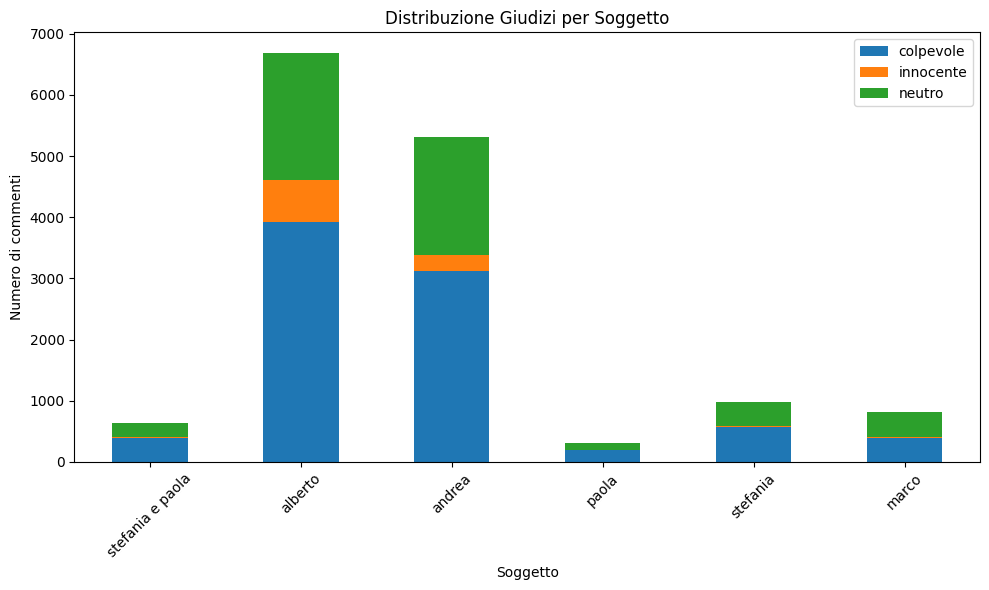

In [11]:
df_riepilogo[["colpevole", "innocente", "neutro"]].plot(
    kind="bar", stacked=True, figsize=(10, 6),
    title="Distribuzione Giudizi per Soggetto"
)
plt.ylabel("Numero di commenti")
plt.xlabel("Soggetto")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


== Distribuzione Giudizi per Genere ==
+-----------+-------------+-------------+----------+----------+---------------+---------------+------------+
|           |   colpevole |   innocente |   neutro |   totale |   % colpevole |   % innocente |   % neutro |
+===========+=============+=============+==========+==========+===============+===============+============+
| femminile |        1137 |          39 |      735 |     1911 |         59.5  |          2.04 |      38.46 |
+-----------+-------------+-------------+----------+----------+---------------+---------------+------------+
| maschile  |        7446 |         954 |     4407 |    12807 |         58.14 |          7.45 |      34.41 |
+-----------+-------------+-------------+----------+----------+---------------+---------------+------------+


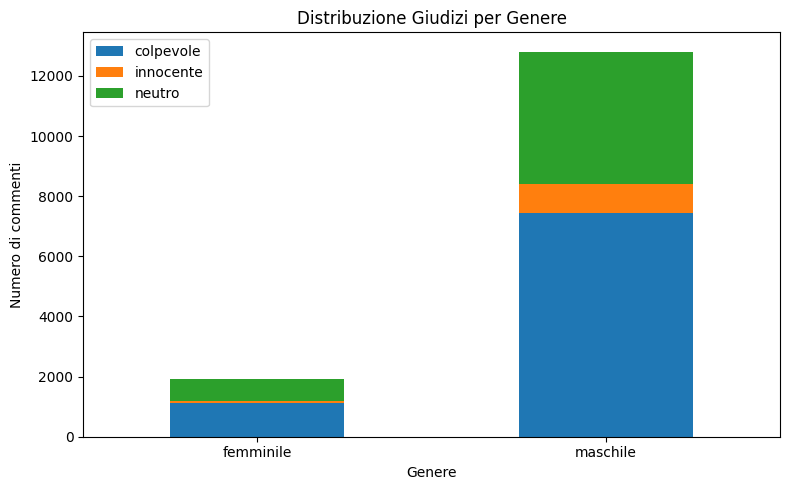

In [12]:
df_genere = pd.DataFrame(giudizi_per_genere).T
df_genere["totale"] = df_genere.sum(axis=1)

for col in ["colpevole", "innocente", "neutro"]:
    df_genere[f"% {col}"] = 100 * df_genere[col] / df_genere["totale"]

print("\n== Distribuzione Giudizi per Genere ==")
print(tabulate(df_genere.round(2), headers='keys', tablefmt='grid'))

df_genere[["colpevole", "innocente", "neutro"]].plot(
    kind="bar", stacked=True, figsize=(8, 5),
    title="Distribuzione Giudizi per Genere"
)
plt.ylabel("Numero di commenti")
plt.xlabel("Genere")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()